# Personalize Ranking Example <a class="anchor" id="top"></a>

In this notebook, you will choose a dataset and prepare it for use with Amazon Personalize Batch Recommendations.

1. [Choose a dataset or data source](#source)
1. [Prepare your data](#prepare)
1. [Create dataset groups and the interactions dataset](#group_dataset)
1. [Configure an S3 bucket and an IAM role](#bucket_role)
1. [Import the interactions data](#import)
1. [Create solutions](#solutions)
1. [Create campaigns](#create)
1. [Interact with campaigns](#interact)
1. [Clean up](#cleanup)

## Introduction <a class="anchor" id="intro"></a>

For the most part, the algorithms in Amazon Personalize (called recipes) look to solve different tasks, explained here:

1. **HRNN & HRNN-Metadata** - Recommends items based on previous user interactions with items.
1. **HRNN-Coldstart** - Recommends new items for which interaction data is not yet available.
1. **Personalized-Ranking** - Takes a collection of items and then orders them in probable order of interest using an HRNN-like approach.
1. **SIMS (Similar Items)** - Given one item, recommends other items also interacted with by users.
1. **Popularity-Count** - Recommends the most popular items, if HRNN or HRNN-Metadata do not have an answer - this is returned by default.

No matter the use case, the algorithms all share a base of learning on user-item-interaction data which is defined by 3 core attributes:

1. **UserID** - The user who interacted
1. **ItemID** - The item the user interacted with
1. **Timestamp** - The time at which the interaction occurred

We also support event types and event values defined by:

1. **Event Type** - Categorical label of an event (browse, purchased, rated, etc).
1. **Event Value** - A value corresponding to the event type that occurred. Generally speaking, we look for normalized values between 0 and 1 over the event types. For example, if there are three phases to complete a transaction (clicked, added-to-cart, and purchased), then there would be an event_value for each phase as 0.33, 0.66, and 1.0 respectfully.

The event type and event value fields are additional data which can be used to filter the data sent for training the personalization model. In this particular exercise we will not have an event type or event value. 

## Choose a dataset or data source <a class="anchor" id="source"></a>
[Back to top](#top)

As we mentioned, the user-item-iteraction data is key for getting started with the service. This means we need to look for use cases that generate that kind of data, a few common examples are:

1. Video-on-demand applications
1. E-commerce platforms
1. Social media aggregators / platforms

There are a few guidelines for scoping a problem suitable for Personalize. We recommend the values below as a starting point, although the [official limits](https://docs.aws.amazon.com/personalize/latest/dg/limits.html) lie a little lower.

* Authenticated users
* At least 50 unique users
* At least 100 unique items
* At least 2 dozen interactions for each user 

Most of the time this is easily attainable, and if you are low in one category, you can often make up for it by having a larger number in another category.

Generally speaking your data will not arrive in a perfect form for Personalize, and will take some modification to be structured correctly. This notebook looks to guide you through all of that. 

To begin with, we are going to use the MovieLens 100k dataset. These are records of the movie rating behavior of its users. The data fits our guidelines with a large number for users, items, and interactions.

First, you will download the dataset and unzip it in a new folder using the code below.

Take a look at the data files you have downloaded.

## Prepare your data <a class="anchor" id="prepare"></a>
[Back to top](#top)

The next thing to be done is to load the data and confirm the data is in a good state, then save it to a CSV where it is ready to be used with Amazon Personalize.

To get started, import a collection of Python libraries commonly used in data science.

In [7]:
## intrim solution 

!aws s3 cp s3://sagemaker-iris-yianc/athena-result/amz-review-u-i-2015-h/2020/12/12/eed4c9c7-6b78-4e7a-bd2d-9ec9ff328e3d.csv user-item.csv 

download: s3://sagemaker-iris-yianc/athena-result/amz-review-u-i-2015-h/2020/12/12/eed4c9c7-6b78-4e7a-bd2d-9ec9ff328e3d.csv to ./user-item.csv


In [2]:
import time
from time import sleep
import json
from datetime import datetime
import numpy as np
import boto3
import pandas as pd

Next,open the data file and take a look at the first several rows.

In [3]:
data_dir = './'
original_data = pd.read_csv(data_dir + 'user-item.csv', delimiter=',')
# original_data = original_data.rename(columns={0: "user", 1: "item", 2:"rating", 3:"timestamp"})
original_data.head(5)

,product_id,product_category,customer_id,star_rating,timestamp
0,B00RP4XVFU,Digital_Ebook_Purchase,9979839,5,1424649600
1,B00QFPEOQA,Health_&_Personal_Care,9979839,5,1424822400
2,B0052P21K0,Home_Improvement,9979839,5,1424304000
3,B00Q375GVC,Health_&_Personal_Care,9979839,5,1420243200
4,B00TABYZX8,Wireless,9979839,5,1424822400


In [4]:
original_data = original_data.rename(columns={"customer_id": "USER_ID", "product_id": "ITEM_ID", "star_rating":"EVENT_VALUE", 'timestamp':'TIMESTAMP'})
original_data.head()


,ITEM_ID,product_category,USER_ID,EVENT_VALUE,TIMESTAMP
0,B00RP4XVFU,Digital_Ebook_Purchase,9979839,5,1424649600
1,B00QFPEOQA,Health_&_Personal_Care,9979839,5,1424822400
2,B0052P21K0,Home_Improvement,9979839,5,1424304000
3,B00Q375GVC,Health_&_Personal_Care,9979839,5,1420243200
4,B00TABYZX8,Wireless,9979839,5,1424822400


In [5]:
original_data = original_data.drop(['product_category'], axis=1)

That's better. Now that the data has been successfully loaded into memory, let's extract some additional information. First, calculate some basic statistics from the data.

In [6]:
original_data.describe()

,USER_ID,EVENT_VALUE,TIMESTAMP
count,5.592168e+07,5.592168e+07,5.592168e+07
mean,2.895096e+07,4.299292e+00,1.395175e+09
std,1.558575e+07,1.140404e+00,6.204552e+07
min,1.000500e+04,1.000000e+00,8.079264e+08
25%,1.501766e+07,4.000000e+00,1.384992e+09
50%,2.837718e+07,5.000000e+00,1.417997e+09
75%,4.363551e+07,5.000000e+00,1.429402e+09
max,5.309657e+07,5.000000e+00,1.440979e+09


This shows that we have a good range of values for `userID` and `movieID`. Next, it is always a good idea to confirm the data format.

In [7]:
original_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55921681 entries, 0 to 55921680
Data columns (total 4 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   ITEM_ID      object
 1   USER_ID      int64 
 2   EVENT_VALUE  int64 
 3   TIMESTAMP    int64 
dtypes: int64(3), object(1)
memory usage: 1.7+ GB


After manipulating the data, always confirm if the data format has changed.

 Amazon Personalize has default column names for users, items, and timestamp. These default column names are `USER_ID`, `ITEM_ID`, AND `TIMESTAMP`. So the final modification to the dataset is to replace the existing column headers with the default headers.

In [9]:

original_data['EVENT_TYPE'] = original_data.apply(lambda x: "rating", axis=1)

original_data.head()

,ITEM_ID,USER_ID,EVENT_VALUE,TIMESTAMP,EVENT_TYPE
0,B00RP4XVFU,9979839,5,1424649600,rating
1,B00QFPEOQA,9979839,5,1424822400,rating
2,B0052P21K0,9979839,5,1424304000,rating
3,B00Q375GVC,9979839,5,1420243200,rating
4,B00TABYZX8,9979839,5,1424822400,rating


In [32]:
original_data.head()

,ITEM_ID,USER_ID,EVENT_VALUE,TIMESTAMP,EVENT_TYPE
0,B00RP4XVFU,9979839,5,1424649600,rating
1,B00QFPEOQA,9979839,5,1424822400,rating
2,B0052P21K0,9979839,5,1424304000,rating
3,B00Q375GVC,9979839,5,1420243200,rating
4,B00TABYZX8,9979839,5,1424822400,rating


That's it! At this point the data is ready to go, and we just need to save it as a CSV file.

In [29]:
interactions_filename = "interactions.csv"
original_data.to_csv((data_dir+"/"+interactions_filename), index=False, float_format='%.0f')

## Create dataset groups and the interactions dataset <a class="anchor" id="group_dataset"></a>
[Back to top](#top)

The highest level of isolation and abstraction with Amazon Personalize is a *dataset group*. Information stored within one of these dataset groups has no impact on any other dataset group or models created from one - they are completely isolated. This allows you to run many experiments and is part of how we keep your models private and fully trained only on your data. 

Before importing the data prepared earlier, there needs to be a dataset group and a dataset added to it that handles the interactions.

Dataset groups can house the following types of information:

* User-item-interactions
* Event streams (real-time interactions)
* User metadata
* Item metadata

Before we create the dataset group and the dataset for our interaction data, let's validate that your environment can communicate successfully with Amazon Personalize.

In [11]:
# Configure the SDK to Personalize:
personalize = boto3.client('personalize')
personalize_runtime = boto3.client('personalize-runtime')

### Create the dataset group

The following cell will create a new dataset group with the name `personalize-ranking-ml100k`.

In [14]:
create_dataset_group_response = personalize.create_dataset_group(
    name = "personalize-ranking-amz-review"
)

dataset_group_arn = create_dataset_group_response['datasetGroupArn']
print(json.dumps(create_dataset_group_response, indent=2))

{
  "datasetGroupArn": "arn:aws:personalize:us-east-1:230755935769:dataset-group/personalize-ranking-amz-review",
  "ResponseMetadata": {
    "RequestId": "c39939ea-2ef4-4da2-a7d9-93cf85011057",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Sat, 12 Dec 2020 07:04:39 GMT",
      "x-amzn-requestid": "c39939ea-2ef4-4da2-a7d9-93cf85011057",
      "content-length": "109",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


Before we can use the dataset group, it must be active. This can take a minute or two. Execute the cell below and wait for it to show the ACTIVE status. It checks the status of the dataset group every second, up to a maximum of 3 hours.

In [15]:
max_time = time.time() + 3*60*60 # 3 hours
while time.time() < max_time:
    describe_dataset_group_response = personalize.describe_dataset_group(
        datasetGroupArn = dataset_group_arn
    )
    status = describe_dataset_group_response["datasetGroup"]["status"]
    print("DatasetGroup: {}".format(status))
    
    if status == "ACTIVE" or status == "CREATE FAILED":
        break
        
    time.sleep(60)

DatasetGroup: CREATE PENDING
DatasetGroup: ACTIVE


Now that you have a dataset group, you can create a dataset for the interaction data.

### Create the dataset

First, define a schema to tell Amazon Personalize what type of dataset you are uploading. There are several reserved and mandatory keywords required in the schema, based on the type of dataset. More detailed information can be found in the [documentation](https://docs.aws.amazon.com/personalize/latest/dg/how-it-works-dataset-schema.html).

Here, you will create a schema for interactions data, which needs the `USER_ID`, `ITEM_ID`, and `TIMESTAMP` fields. These must be defined in the same order in the schema as they appear in the dataset.

In [16]:
interactions_schema = {
    "type": "record",
    "name": "Interactions",
    "namespace": "com.amazonaws.personalize.schema",
    "fields": [
        {
            "name": "USER_ID",
            "type": "string"
        },
        {
            "name": "ITEM_ID",
            "type": "string"
        },
        {
          "name": "EVENT_VALUE",
          "type": [
             "float",
             "null"
          ]
        },
        {
            "name": "TIMESTAMP",
            "type": "long"
        },
        {
            "name": "EVENT_TYPE",
            "type": "string"
        },
    ],
    "version": "1.0"
}

create_schema_response = personalize.create_schema(
    name = "p13n-amz-review-ranking",
    schema = json.dumps(interactions_schema)
)

schema_arn = create_schema_response['schemaArn']
print(json.dumps(create_schema_response, indent=2))

{
  "schemaArn": "arn:aws:personalize:us-east-1:230755935769:schema/p13n-amz-review-ranking",
  "ResponseMetadata": {
    "RequestId": "cad97703-2c9d-47da-a25d-3ea07060d2bc",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Sat, 12 Dec 2020 07:07:09 GMT",
      "x-amzn-requestid": "cad97703-2c9d-47da-a25d-3ea07060d2bc",
      "content-length": "89",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


With a schema created, you can create a dataset within the dataset group. Note, this does not load the data yet. This will happen a few steps later.

In [17]:
dataset_type = "INTERACTIONS"
create_dataset_response = personalize.create_dataset(
    name = "personalize-ranking-amz-review",
    datasetType = dataset_type,
    datasetGroupArn = dataset_group_arn,
    schemaArn = schema_arn
)

interactions_dataset_arn = create_dataset_response['datasetArn']
print(json.dumps(create_dataset_response, indent=2))

{
  "datasetArn": "arn:aws:personalize:us-east-1:230755935769:dataset/personalize-ranking-amz-review/INTERACTIONS",
  "ResponseMetadata": {
    "RequestId": "120b507e-70dc-4643-9afd-a2731eb4b318",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Sat, 12 Dec 2020 07:07:51 GMT",
      "x-amzn-requestid": "120b507e-70dc-4643-9afd-a2731eb4b318",
      "content-length": "111",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


## Configure an S3 bucket and an IAM  role <a class="anchor" id="bucket_role"></a>
[Back to top](#top)

So far, we have downloaded, manipulated, and saved the data onto the Amazon EBS instance attached to instance running this Jupyter notebook. However, Amazon Personalize will need an S3 bucket to act as the source of your data, as well as IAM roles for accessing that bucket. Let's set all of that up.

Use the metadata stored on the instance underlying this Amazon SageMaker notebook, to determine the region it is operating in. If you are using a Jupyter notebook outside of Amazon SageMaker, simply define the region as a string below. The Amazon S3 bucket needs to be in the same region as the Amazon Personalize resources we have been creating so far.

In [18]:
with open('/opt/ml/metadata/resource-metadata.json') as notebook_info:
    data = json.load(notebook_info)
    resource_arn = data['ResourceArn']
    region = resource_arn.split(':')[3]
print(region)

us-east-1


Amazon S3 bucket names are globally unique. To create a unique bucket name, the code below will append the string `personalizepoc` to your AWS account number. Then it creates a bucket with this name in the region discovered in the previous cell.

In [30]:
s3 = boto3.client('s3')
suffix = str(np.random.uniform())[4:9]
bucket_name = "p13n-amz-review-ranking-demo-"+   suffix        # replace with the name of your S3 bucket
print(bucket_name)
if region != "us-east-1":
    s3.create_bucket(Bucket=bucket_name, CreateBucketConfiguration={'LocationConstraint': region})
else:
    s3.create_bucket(Bucket=bucket_name)

p13n-amz-review-ranking-demo-90409


### Upload data to S3

Now that your Amazon S3 bucket has been created, upload the CSV file of our user-item-interaction data. 

In [34]:
interactions_file_path = data_dir  + interactions_filename
boto3.Session().resource('s3').Bucket(bucket_name).Object(interactions_filename).upload_file(interactions_file_path)
interactions_s3DataPath = "s3://"+bucket_name+"/"+interactions_filename
interactions_s3DataPath

's3://p13n-amz-review-ranking-demo-90409/interactions.csv'

### Set the S3 bucket policy
Amazon Personalize needs to be able to read the contents of your S3 bucket. So add a bucket policy which allows that.

In [50]:
bucket_name

'p13n-amz-review-ranking-demo-90409'

In [49]:
policy = {
    "Version": "2012-10-17",
    "Id": "PersonalizeS3BucketAccessPolicy",
    "Statement": [
        {
            "Sid": "PersonalizeS3BucketAccessPolicy",
            "Effect": "Allow",
            "Principal": {
                "Service": "personalize.amazonaws.com"
            },
            "Action": [
                "s3:*Object",
                "s3:ListBucket"
            ],
            "Resource": [
                "arn:aws:s3:::{}".format(bucket_name),
                "arn:aws:s3:::{}/*".format(bucket_name)
            ]
        }
    ]
}

s3.put_bucket_policy(Bucket=bucket_name, Policy=json.dumps(policy))

{'ResponseMetadata': {'RequestId': '265245A3115071D6',
  'HostId': 'jaa1BpqTDWGoNGVvzXNJqy5Bv8+Qs1qIO828Xz6FawWQeFUhJaETUmZArWUtASne3xFTiNuP3MY=',
  'HTTPStatusCode': 204,
  'HTTPHeaders': {'x-amz-id-2': 'jaa1BpqTDWGoNGVvzXNJqy5Bv8+Qs1qIO828Xz6FawWQeFUhJaETUmZArWUtASne3xFTiNuP3MY=',
   'x-amz-request-id': '265245A3115071D6',
   'date': 'Sat, 12 Dec 2020 07:35:29 GMT',
   'server': 'AmazonS3'},
  'RetryAttempts': 0}}

### Create an IAM role

Amazon Personalize needs the ability to assume roles in AWS in order to have the permissions to execute certain tasks. Let's create an IAM role and attach the required policies to it. The code below attaches very permissive policies; please use more restrictive policies for any production application.

In [44]:
iam = boto3.client("iam")

role_name = "AmzReviewRankingRole"
assume_role_policy_document = {
    "Version": "2012-10-17",
    "Statement": [
        {
          "Effect": "Allow",
          "Principal": {
            "Service": "personalize.amazonaws.com"
          },
          "Action": "sts:AssumeRole"
        }
    ]
}

# create_role_response = iam.create_role(
#     RoleName = role_name,
#     AssumeRolePolicyDocument = json.dumps(assume_role_policy_document)
# )

# AmazonPersonalizeFullAccess provides access to any S3 bucket with a name that includes "personalize" or "Personalize" 
# if you would like to use a bucket with a different name, please consider creating and attaching a new policy
# that provides read access to your bucket or attaching the AmazonS3ReadOnlyAccess policy to the role
policy_arn = "arn:aws:iam::aws:policy/service-role/AmazonPersonalizeFullAccess"
iam.attach_role_policy(
    RoleName = role_name,
    PolicyArn = policy_arn
)

# Now add S3 support
iam.attach_role_policy(
    PolicyArn='arn:aws:iam::aws:policy/AmazonS3FullAccess',
    RoleName=role_name
)
time.sleep(60) # wait for a minute to allow IAM role policy attachment to propagate

role_arn = create_role_response["Role"]["Arn"]
print(role_arn)

arn:aws:iam::230755935769:role/AmzReviewRankingRole


In [45]:
role_arn="arn:aws:iam::230755935769:role/PersonalizeAmzRole"

## Import the interactions data <a class="anchor" id="import"></a>
[Back to top](#top)

Earlier you created the dataset group and dataset to house your information, so now you will execute an import job that will load the data from the S3 bucket into the Amazon Personalize dataset. 

In [28]:
"s3://{}/{}".format(bucket_name, interactions_filename)

's3://p13n-amz-review-ranking-demo-29886/interactions.csv'

In [51]:
create_dataset_import_job_response = personalize.create_dataset_import_job(
    jobName = "p13n-amz-review-ranking-job-2",
    datasetArn = interactions_dataset_arn,
    dataSource = {
        "dataLocation": "s3://{}/{}".format(bucket_name, interactions_filename)
    },
    roleArn = role_arn
)

dataset_import_job_arn = create_dataset_import_job_response['datasetImportJobArn']
print(json.dumps(create_dataset_import_job_response, indent=2))

{
  "datasetImportJobArn": "arn:aws:personalize:us-east-1:230755935769:dataset-import-job/p13n-amz-review-ranking-job-2",
  "ResponseMetadata": {
    "RequestId": "abc14468-311f-46fa-81d6-f6c0450aa56e",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Sat, 12 Dec 2020 07:36:06 GMT",
      "x-amzn-requestid": "abc14468-311f-46fa-81d6-f6c0450aa56e",
      "content-length": "117",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


Before we can use the dataset, the import job must be active. Execute the cell below and wait for it to show the ACTIVE status. It checks the status of the import job every second, up to a maximum of 3 hours.

Importing the data can take some time, depending on the size of the dataset. In this workshop, the data import job should take around 15 minutes.

In [53]:
%%time

max_time = time.time() + 3*60*60 # 3 hours
while time.time() < max_time:
    describe_dataset_import_job_response = personalize.describe_dataset_import_job(
        datasetImportJobArn = dataset_import_job_arn
    )
    status = describe_dataset_import_job_response["datasetImportJob"]['status']
    print("DatasetImportJob: {}".format(status))
    
    if status == "ACTIVE" or status == "CREATE FAILED":
        break
        
    time.sleep(60)

DatasetImportJob: ACTIVE
CPU times: user 13.3 ms, sys: 350 µs, total: 13.6 ms
Wall time: 1.07 s


When the dataset import is active, you are ready to start building models with SIMS, Personalized-Ranking, Popularity-Count, and HRNN. This process will continue in other notebooks. Run the cell below before moving on to store a few values for usage in the next notebooks.

## Create solutions <a class="anchor" id="solutions"></a>
[Back to top](#top)

In this notebook, you will create solutions with the following recipe:

`aws-personalized-ranking`


In Amazon Personalize, a specific variation of an algorithm is called a recipe. Different recipes are suitable for different situations. A trained model is called a solution, and each solution can have many versions that relate to a given volume of data when the model was trained.

To start, we will list all the recipes that are supported. This will allow you to select one and use that to build your model.

In [54]:
personalize.list_recipes()

{'recipes': [{'name': 'aws-hrnn',
   'recipeArn': 'arn:aws:personalize:::recipe/aws-hrnn',
   'status': 'ACTIVE',
   'creationDateTime': datetime.datetime(2019, 6, 10, 0, 0, tzinfo=tzlocal()),
   'lastUpdatedDateTime': datetime.datetime(2020, 8, 25, 16, 57, 0, 148000, tzinfo=tzlocal())},
  {'name': 'aws-hrnn-coldstart',
   'recipeArn': 'arn:aws:personalize:::recipe/aws-hrnn-coldstart',
   'status': 'ACTIVE',
   'creationDateTime': datetime.datetime(2019, 6, 10, 0, 0, tzinfo=tzlocal()),
   'lastUpdatedDateTime': datetime.datetime(2020, 8, 25, 16, 57, 0, 148000, tzinfo=tzlocal())},
  {'name': 'aws-hrnn-metadata',
   'recipeArn': 'arn:aws:personalize:::recipe/aws-hrnn-metadata',
   'status': 'ACTIVE',
   'creationDateTime': datetime.datetime(2019, 6, 10, 0, 0, tzinfo=tzlocal()),
   'lastUpdatedDateTime': datetime.datetime(2020, 8, 25, 16, 57, 0, 148000, tzinfo=tzlocal())},
  {'name': 'aws-personalized-ranking',
   'recipeArn': 'arn:aws:personalize:::recipe/aws-personalized-ranking',
   's

### Personalized Ranking

Personalized Ranking is an interesting application of HRNN. Instead of just recommending what is most probable for the user in question, this algorithm takes in a user and a list of items as well. The items are then rendered back in the order of most probable relevance for the user. The use case here is for filtering on genre for example, or when you have a broad collection that you would like better ordered for a particular user.

In [55]:
rerank_recipe_arn = "arn:aws:personalize:::recipe/aws-personalized-ranking"

#### Create the solution

As with the previous solution, start by creating the solution first. Although you provide the dataset ARN in this step, the model is not yet trained. See this as an identifier instead of a trained model.

In [56]:
rerank_create_solution_response = personalize.create_solution(
    name = "p13n-amz-review-ranking",
    datasetGroupArn = dataset_group_arn,
    recipeArn = rerank_recipe_arn
)

rerank_solution_arn = rerank_create_solution_response['solutionArn']
print(json.dumps(rerank_create_solution_response, indent=2))

{
  "solutionArn": "arn:aws:personalize:us-east-1:230755935769:solution/p13n-amz-review-ranking",
  "ResponseMetadata": {
    "RequestId": "689174d7-25f6-4698-8328-b5a7537f853c",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Sat, 12 Dec 2020 13:11:11 GMT",
      "x-amzn-requestid": "689174d7-25f6-4698-8328-b5a7537f853c",
      "content-length": "93",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


#### Create the solution version

Once you have a solution, you need to create a version in order to complete the model training. The training can take a while to complete, upwards of 25 minutes, and an average of 35 minutes for this recipe with our dataset. Normally, we would use a while loop to poll until the task is completed. However the task would block other cells from executing, and the goal here is to create many models and deploy them quickly. So we will set up the while loop for all of the solutions further down in the notebook. There, you will also find instructions for viewing the progress in the AWS console.

In [57]:
rerank_create_solution_version_response = personalize.create_solution_version(
    solutionArn = rerank_solution_arn
)

In [58]:
rerank_solution_version_arn = rerank_create_solution_version_response['solutionVersionArn']
print(json.dumps(rerank_create_solution_version_response, indent=2))

{
  "solutionVersionArn": "arn:aws:personalize:us-east-1:230755935769:solution/p13n-amz-review-ranking/04fe49a3",
  "ResponseMetadata": {
    "RequestId": "ff5358a5-38f5-4bec-afb1-4851e851532f",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Sat, 12 Dec 2020 13:11:17 GMT",
      "x-amzn-requestid": "ff5358a5-38f5-4bec-afb1-4851e851532f",
      "content-length": "109",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


### View solution creation status

As promised, how to view the status updates in the console:

* In another browser tab you should already have the AWS Console up from opening this notebook instance. 
* Switch to that tab and search at the top for the service `Personalize`, then go to that service page. 
* Click `View dataset groups`.
* Click the name of your dataset group, most likely something with POC in the name.
* Click `Solutions and recipes`.
* You will now see a list of all of the solutions you created above,  including a column with the status of the solution versions. Once it is `Active`, your solution is ready to be reviewed. It is also capable of being deployed.

Or simply run the cell below to keep track of the solution version creation status.

In [65]:
in_progress_solution_versions = [
    rerank_solution_version_arn
]

max_time = time.time() + 3*60*60 # 3 hours
while time.time() < max_time:
    for solution_version_arn in in_progress_solution_versions:
        version_response = personalize.describe_solution_version(
            solutionVersionArn = solution_version_arn
        )
        status = version_response["solutionVersion"]["status"]
        
        if status == "ACTIVE":
            print("Build succeeded for {}".format(solution_version_arn))
            in_progress_solution_versions.remove(solution_version_arn)
        elif status == "CREATE FAILED":
            print("Build failed for {}".format(solution_version_arn))
            in_progress_solution_versions.remove(solution_version_arn)
    
    if len(in_progress_solution_versions) <= 0:
        break
    else:
        print("At least one solution build is still in progress")
        
    time.sleep(60)

Build succeeded for arn:aws:personalize:us-east-1:230755935769:solution/p13n-amz-review-ranking/04fe49a3


## Create campaigns <a class="anchor" id="create"></a>
[Back to top](#top)

A campaign is a hosted solution version; an endpoint which you can query for recommendations. Pricing is set by estimating throughput capacity (requests from users for personalization per second). When deploying a campaign, you set a minimum throughput per second (TPS) value. This service, like many within AWS, will automatically scale based on demand, but if latency is critical, you may want to provision ahead for larger demand. For this POC and demo, all minimum throughput thresholds are set to 1. For more information, see the [pricing page](https://aws.amazon.com/personalize/pricing/).

Let's start deploying the campaigns.

### Personalized Ranking

Deploy a campaign for your personalized ranking solution version. It can take around 10 minutes to deploy a campaign. Normally, we would use a while loop to poll until the task is completed. However the task would block other cells from executing, and the goal here is to create multiple campaigns. So we will set up the while loop for all of the campaigns further down in the notebook. There, you will also find instructions for viewing the progress in the AWS console.

In [63]:
rerank_create_campaign_response = personalize.create_campaign(
    name = "p13n-amz-review-poc-rerank",
    solutionVersionArn = rerank_solution_version_arn,
    minProvisionedTPS = 1
)

rerank_campaign_arn = rerank_create_campaign_response['campaignArn']
print(json.dumps(rerank_create_campaign_response, indent=2))

{
  "campaignArn": "arn:aws:personalize:us-east-1:230755935769:campaign/p13n-amz-review-poc-rerank",
  "ResponseMetadata": {
    "RequestId": "b7a70e80-e0d8-43e1-9965-9a1bd85327b7",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Sun, 13 Dec 2020 12:48:13 GMT",
      "x-amzn-requestid": "b7a70e80-e0d8-43e1-9965-9a1bd85327b7",
      "content-length": "96",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


### View campaign creation status

As promised, how to view the status updates in the console:

* In another browser tab you should already have the AWS Console up from opening this notebook instance. 
* Switch to that tab and search at the top for the service `Personalize`, then go to that service page. 
* Click `View dataset groups`.
* Click the name of your dataset group, most likely something with POC in the name.
* Click `Campaigns`.
* You will now see a list of all of the campaigns you created above, including a column with the status of the campaign. Once it is `Active`, your campaign is ready to be queried.

Or simply run the cell below to keep track of the campaign creation status.

In [64]:
in_progress_campaigns = [
    rerank_campaign_arn
]

max_time = time.time() + 3*60*60 # 3 hours
while time.time() < max_time:
    for campaign_arn in in_progress_campaigns:
        version_response = personalize.describe_campaign(
            campaignArn = campaign_arn
        )
        status = version_response["campaign"]["status"]
        
        if status == "ACTIVE":
            print("Build succeeded for {}".format(campaign_arn))
            in_progress_campaigns.remove(campaign_arn)
        elif status == "CREATE FAILED":
            print("Build failed for {}".format(campaign_arn))
            in_progress_campaigns.remove(campaign_arn)
    
    if len(in_progress_campaigns) <= 0:
        break
    else:
        print("At least one campaign build is still in progress")
        
    time.sleep(60)

At least one campaign build is still in progress
At least one campaign build is still in progress
At least one campaign build is still in progress
At least one campaign build is still in progress
At least one campaign build is still in progress
At least one campaign build is still in progress
At least one campaign build is still in progress
At least one campaign build is still in progress
At least one campaign build is still in progress
Build succeeded for arn:aws:personalize:us-east-1:230755935769:campaign/p13n-amz-review-poc-rerank


In [ ]:
## progress this afternoon 

## Interact with campaigns <a class="anchor" id="interact"></a>
[Back to top](#top)

Now that all campaigns are deployed and active, we can start to get recommendations via an API call. Each of the campaigns is based on a different recipe, which behave in slightly different ways because they serve different use cases. We will cover each campaign in a different order than used in previous notebooks, in order to deal with the possible complexities in ascending order (i.e. simplest first).

First, let's create a supporting function to help make sense of the results returned by a Personalize campaign. Personalize returns only an `item_id`. This is great for keeping data compact, but it means you need to query a database or lookup table to get a human-readable result for the notebooks. We will create a helper function to return a human-readable result from the MovieLens dataset.

Start by loading in the dataset which we can use for our lookup table.

In [76]:
items_df = pd.read_csv('product.csv')
items_df = items_df.reset_index()

In [81]:
c_row = items_df[items_df['product_id']== "B000CO7WPK"].iloc[0] 
title = c_row['product_title'] 
category = c_row['product_category'] 
(title, category) 
# items_df.head()

('KYB 344055 Excel-G Gas Shock', 'Automotive')

In [96]:
def get_product_by_id(product_id, items_df):
    """
    This takes in an movie_id from Personalize so it will be a string,
    converts it to an int, and then does a lookup in a default or specified
    dataframe.
    
    A really broad try/except clause was added in case anything goes wrong.
    
    Feel free to add more debugging or filtering here to improve results if
    you hit an error.
    """
    try:
        c_row = items_df[items_df['product_id']==product_id].iloc[0]
        title = c_row['product_title'] 
        category = c_row['product_category'] 

        return [title, category]
    except:
        return "Error obtaining product info"

Now let's test a few simple values to check our error catching.

In [74]:
# A known good id
print(get_product_by_id(product_id="B00KKEI8ZA", items_df=items_df))

Error obtaining movie info


Great! Now we have a way of rendering results. 

### Personalized Ranking

The core use case for personalized ranking is to take a collection of items and to render them in priority or probable order of interest for a user. To demonstrate this, we will need a random user and a random collection of 25 items.

In [83]:
master_user="master_user"
master_user_password="master_user_password"
elastic_search_endpoint="elastic_search_endpoint"

In [118]:
import requests 

r = requests.get('https://{}/product/product/_search?q=product_title:coach&size=100'.format(elastic_search_endpoint), auth=(master_user, master_user_password))
rjson = r.json()
rjson 

{'took': 4740,
 'timed_out': False,
 '_shards': {'total': 5, 'successful': 5, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 4095, 'relation': 'eq'},
  'max_score': 12.69479,
  'hits': [{'_index': 'product',
    '_type': 'product',
    '_id': 'xz6EUnYB7ZcjQTgaLI97',
    '_score': 12.69479,
    '_source': {'product_id': 'B005DSNBI2',
     'product_category': 'Beauty',
     'product_title': 'COACH SIGNATURE by Coach'}},
   {'_index': 'product',
    '_type': 'product',
    '_id': 'qeq-UXYB1EYWinhndsNC',
    '_score': 12.205915,
    '_source': {'product_id': '6305826811',
     'product_category': 'Video_DVD',
     'product_title': 'Coach'}},
   {'_index': 'product',
    '_type': 'product',
    '_id': '9gilUXYBXrWQULoffXeG',
    '_score': 12.205915,
    '_source': {'product_id': '6305826811',
     'product_category': 'Video_DVD',
     'product_title': 'Coach'}},
   {'_index': 'product',
    '_type': 'product',
    '_id': 'lGBsXnYB7ZcjQTga_h6T',
    '_score': 12.205915,
    '_sourc

In [119]:
items_from_search = [] 
for h in rjson['hits']['hits']:
    items_from_search.append(h['_source']['product_id'])

rerank_user = 9979839



Now build a nice dataframe that shows the input data.

In [120]:
rerank_list = []
for item in items_from_search:
    movie = get_product_by_id(item, items_df)

    rerank_list.append(movie)
rerank_df = pd.DataFrame(rerank_list)
rerank_df

,0,1
0,COACH SIGNATURE by Coach,Beauty
1,Coach,Video_DVD
2,Coach,Video_DVD
3,Coach,Digital_Video_Download
4,Coach,Digital_Video_Download
...,...,...
95,Coach Peyton Cora,Shoes
96,Singing Coach Kidz,Software
97,The Cheerleader's Coach,Digital_Ebook_Purchase
98,Coach Poppy Perfume by Coach for women Personal Fragrances,Beauty


Then make the personalized ranking API call.

,ITEM_ID,USER_ID,EVENT_VALUE,TIMESTAMP,EVENT_TYPE,index,product_id,product_category,product_title
0,B00RP4XVFU,9979839,5,1424649600,rating,245005,B00RP4XVFU,Digital_Ebook_Purchase,The Vanished--A Suspense Novel
1,B00QFPEOQA,9979839,5,1424822400,rating,440043,B00QFPEOQA,Health_&_Personal_Care,"SOMNIS - Natural Sleep Aid - Safe, Effective, Non-Habit Forming Supplement. Extra Strength Sleeping Pills Made with Melatonin, Gaba, and L-Tryptophan - 60 Capsules"
2,B0052P21K0,9979839,5,1424304000,rating,1875939,B0052P21K0,Home_Improvement,"Eureka 30"" European Style Stainless Steel Island Mount Range Vent Hood"
3,B00Q375GVC,9979839,5,1420243200,rating,2574926,B00Q375GVC,Health_&_Personal_Care,"Nexgen Biolabs Oxislim Super Antioxidant and Fat Burner, 60 Count"
4,B00TABYZX8,9979839,5,1424822400,rating,431806,B00TABYZX8,Wireless,"Pamalo Easy Installable Car Phone Mount, Good for iPhone 6/5s/5c/4s/4, Samsung Galaxy S5/S4, Amazon Fire Phone, HTC One: Windshield Dashboard Car Mount Holder, Great Cell Phone Cradle"


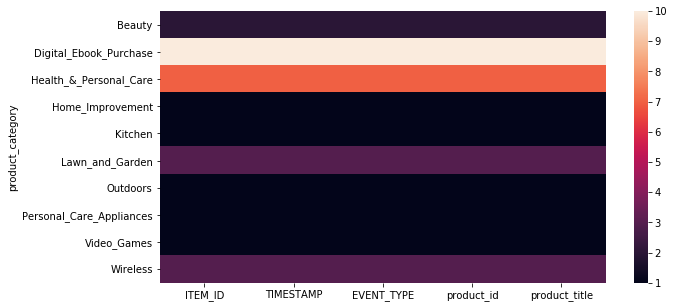

In [121]:
import json

import numpy 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd





def plot_heat_map(df, figsize=(10,7)): 
    df = df.groupby(['product_category']).count()
    df = df.drop(['USER_ID', 'EVENT_VALUE', 'index'], axis=1)
    plt.subplots(figsize=figsize)
    sns.heatmap(df)




tester_df = original_data[original_data['USER_ID']==rerank_user]
all_df = tester_df.merge(items_df, left_on='ITEM_ID', right_on='product_id')
plot_heat_map(all_df, figsize=(10,5))
all_df.head()
# review = tester_df[['positive']+genres].groupby(['positive']).sum()
# plot_heat_map(review, figsize=(10,5))

In [122]:
# Convert user to string:

rerank_item_list = []
for item in items_from_search:
    rerank_item_list.append(str(item))
    
# Get recommended reranking
get_recommendations_response_rerank = personalize_runtime.get_personalized_ranking(
        campaignArn = rerank_campaign_arn,
        userId = str(rerank_user),
        inputList = rerank_item_list
)

get_recommendations_response_rerank

{'ResponseMetadata': {'RequestId': 'd3ecd757-89c4-4bcf-bdbf-36c52770c84e',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/json',
   'date': 'Mon, 14 Dec 2020 08:26:30 GMT',
   'x-amzn-requestid': 'd3ecd757-89c4-4bcf-bdbf-36c52770c84e',
   'content-length': '5737',
   'connection': 'keep-alive'},
  'RetryAttempts': 0},
 'personalizedRanking': [{'itemId': 'B00G6HW8II', 'score': 0.4460057},
  {'itemId': 'B00AEFXOKO', 'score': 0.0832643},
  {'itemId': 'B005EM8FSI', 'score': 0.0765874},
  {'itemId': 'B004ES6TBS', 'score': 0.0724244},
  {'itemId': 'B0045SU5ZI', 'score': 0.0662087},
  {'itemId': 'B004BCX4TC', 'score': 0.0590719},
  {'itemId': 'B004BCZ0TY', 'score': 0.0565927},
  {'itemId': 'B00965EJ02', 'score': 0.0563808},
  {'itemId': 'B003NR7WYO', 'score': 0.0527986},
  {'itemId': 'B0082OKDJO', 'score': 0.0306654},
  {'itemId': 'B005DSNBI2'},
  {'itemId': '6305826811'},
  {'itemId': '6305826811'},
  {'itemId': 'B003QF6W8U'},
  {'itemId': 'B003QFFO7K'},
  {'itemId':

Now add the reranked items as a second column to the original dataframe, for a side-by-side comparison.

In [124]:
ranked_list = []
item_list = get_recommendations_response_rerank['personalizedRanking']
for item in item_list:
    movie = get_product_by_id(item['itemId'], items_df)
    ranked_list.append(movie)
ranked_df = pd.DataFrame(ranked_list, columns = ['Original','Re-Ranked'])
compare_df = pd.concat([rerank_df, ranked_df], axis=1)
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', None)
compare_df

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:8: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


,0,1,Original,Re-Ranked
0,COACH SIGNATURE by Coach,Beauty,Language Coach,Mobile_Apps
1,Coach,Video_DVD,Coach Carter,Video_DVD
2,Coach,Video_DVD,Coach Poppy Flower Perfume By Coach For Women,Beauty
3,Coach,Digital_Video_Download,Coach: Season 4,Video_DVD
4,Coach,Digital_Video_Download,Coach Poppy Perfume by Coach for women Personal Fragrances,Beauty
5,Coach,Digital_Ebook_Purchase,Coach Perfume by Coach for women Personal Fragrances,Beauty
6,Coach,Video_DVD,Coach Poppy Perfume by Coach for women Personal Fragrances,Beauty
7,Coach,Video_DVD,My Diet Coach,Mobile_Apps
8,Coach,Apparel,Coach Legacy By Coach For Women,Beauty
9,Coach,Digital_Video_Download,The Coach House,Digital_Ebook_Purchase


You can see above how each entry was re-ordered based on the model's understanding of the user. This is a popular task when you have a collection of items to surface a user, a list of promotions for example, or if you are filtering on a category and want to show the most likely good items.